In [1]:
import cvxpy as cp
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline, make_smoothing_spline
from nldg.utils import *
from nldg.splines import *

In [2]:
data_setting = 2
if data_setting == 1:
    dtr = gen_data_v2(n=1000)
elif data_setting == 2:
    dtr = gen_data_v3(n=1000, setting=2)
elif data_setting == 3:
    dtr = gen_data_v4(n_easy=1000, n_hard=1000)
elif data_setting == 4:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
else:
    dtr = gen_data_v6(n=1000, noise_std=0.5)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [3]:
def bspline_N(x, knots, degree):
    """
    Evaluate the B-spline basis at points x.
    Returns a design matrix of shape (len(x), M) where M = len(knots) - degree - 1.
    """
    x = np.atleast_1d(x).flatten()
    M = len(knots) - degree - 1
    X_design = np.zeros((len(x), M))
    for i in range(M):
        # Basis function: set coefficient 1 for the i-th basis, 0 otherwise.
        c = np.zeros(M)
        c[i] = 1
        spl = BSpline(knots, c, degree, extrapolate=False)
        X_design[:, i] = spl(x)
    return X_design

def bspline_2der(x, knots, degree, i):
    """
    Evaluate the second derivative of the i-th B-spline basis function at x.
    """
    x = np.atleast_1d(x).flatten()
    M = len(knots) - degree - 1
    c = np.zeros(M)
    c[i] = 1
    spl = BSpline(knots, c, degree, extrapolate=False)
    spl2 = spl.derivative(nu=2)
    return spl2(x)

def omega(knots, degree, grid_points):
    """
    Compute Omega[i,j] = \int [B_i''(x) B_j''(x)] dx by numerical integration.
    """
    M = len(knots) - degree - 1
    Omega = np.zeros((M, M))
    dx = grid_points[1] - grid_points[0]  # assume uniform grid spacing
    for i in range(M):
        Bi2 = bspline_2der(grid_points, knots, degree, i)
        for j in range(M):
            Bj2 = bspline_2der(grid_points, knots, degree, j)
            Omega[i, j] = np.sum(Bi2 * Bj2) * dx
    return Omega

## Minimizing the maximum MSE over training environments

In [4]:
x_min = dtr["X"].min()
x_max = dtr["X"].max()

degree = 3  # cubic splines
n_bases = 10  # number of basis functions

n_internal = n_bases - degree + 1  # number of internal knots
internal_knots = np.linspace(x_min, x_max, n_internal)
knots = np.concatenate((np.repeat(x_min, degree), internal_knots, np.repeat(x_max, degree)))
#knots = np.concatenate((np.repeat(x_min, degree), Xtr_sorted.flatten(), np.repeat(x_max, degree)))
M = len(knots) - degree - 1

# Compute the penalty matrix using a fine grid over the domain.
grid = np.linspace(x_min, x_max, 400)
Omega = omega(knots, degree, grid)

mask_env0 = (Etr == 0)
mask_env1 = (Etr == 1)

N0 = bspline_N(Xtr[mask_env0], knots, degree)
N1 = bspline_N(Xtr[mask_env1], knots, degree)

Y_env0 = Ytr[mask_env0]
Y_env1 = Ytr[mask_env1]

N = bspline_N(Xtr, knots, degree)
Y_pooled = Ytr

_lambda = 0.01

# Classical solution
beta = cp.Variable(M)
objective = cp.Minimize(
    cp.mean(cp.square(Y_pooled - N @ beta)) +
    _lambda * cp.quad_form(beta, Omega)
)
problem = cp.Problem(objective)
problem.solve(solver=cp.SCS)

# Maximin
beta_maximin = cp.Variable(M)
t = cp.Variable(nonneg=True)

constraints = []
constraints.append(cp.mean(cp.square(Y_env0 - N0 @ beta_maximin)) <= t)
constraints.append(cp.mean(cp.square(Y_env1 - N1 @ beta_maximin))<= t)

if data_setting == 2:
    mask_env2 = (Etr == 2)
    N2 = bspline_N(Xtr[mask_env2], knots, degree)
    Y_env2 = Ytr[mask_env2]
    constraints.append(cp.mean(cp.square(Y_env2 - N2 @ beta_maximin)) <= t)

objective_maximin = cp.Minimize(
    t + _lambda * cp.quad_form(beta_maximin, Omega)
)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve()

# Predictions
x_grid = np.linspace(x_min, x_max, 200)
X_grid = bspline_N(x_grid, knots, degree)

preds_erm = X_grid @ beta.value
preds_maximin = X_grid @ beta_maximin.value

In [5]:
# Magging
def obj_magging(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    N_e = bspline_N(Xtr_e, knots, degree)

    beta_e = cp.Variable(M)
    objective = cp.Minimize(
        cp.mean(cp.square(Ytr_e - N_e @ beta_e)) +
        _lambda * cp.quad_form(beta_e, Omega)
    )
    problem = cp.Problem(objective)
    problem.solve()

    preds_envs.append(X_grid @ beta_e.value)
    fitted_envs.append(N @ beta_e.value)

preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)
wmag = minimize(obj_magging, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
preds_magging = np.dot(wmag, preds_envs.T)
fitted_magging = np.dot(wmag, fitted_envs.T)
#n = Xtr.shape[0]
#Gamma = fitted_envs.T @ fitted_envs / n
#q = cp.Variable(n_envs, nonneg=True)
#constraints = [cp.sum(q) == 1]
#objective = cp.Minimize(cp.quad_form(q, Gamma))
#prob = cp.Problem(objective, constraints)
#prob.solve()
#q.value

In [6]:
wmag

array([0.50220085, 0.49779915, 0.        ])

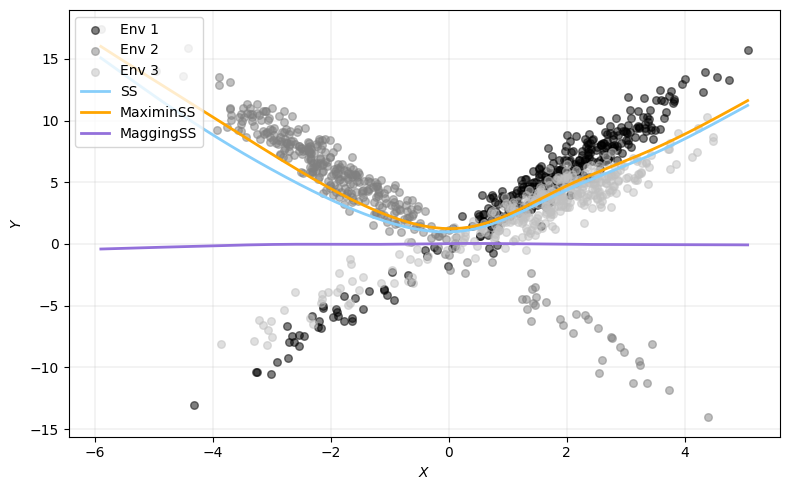

In [7]:
plot_dtr(dtr, x_grid, preds_erm, preds_maximin, preds_magging, saveplot=True, nameplot="preliminary_res_ss")

In [8]:
fitted_erm = N @ beta.value
max_mse(Ytr, fitted_erm, Etr, verbose=True)

Environment 0 MSE: 17.836853660669256
Environment 1 MSE: 21.6928059154672
Environment 2 MSE: 9.389590138809359


np.float64(21.6928059154672)

In [9]:
min_xplvar(Ytr, fitted_erm, Etr, verbose=True)

Environment 0 explained variance: 28.330149861458906
Environment 1 explained variance: 26.339246393146336
Environment 2 explained variance: 8.890155792128384


np.float64(8.890155792128384)

In [10]:
fitted_maximin = N @ beta_maximin.value
max_mse(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 MSE: 19.269453344129957
Environment 1 MSE: 19.26945060819667
Environment 2 MSE: 11.545703658742918


np.float64(19.269453344129957)

In [18]:
min_xplvar(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 explained variance: 21.304577252022145
Environment 1 explained variance: 13.450239255258236
Environment 2 explained variance: 15.2360037606948


np.float64(13.450239255258236)

In [19]:
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 13.604867513002542
Environment 1 MSE: 5.722110330599962
Environment 2 MSE: 1.3953216759972304


np.float64(13.604867513002542)

In [20]:
min_xplvar(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 explained variance: 16.93421871920497
Environment 1 explained variance: 16.962637906452194
Environment 2 explained variance: 17.069122290830677


np.float64(16.93421871920497)

## Maximizing the minimal explained variance over training environments

In [18]:
x_min = dtr["X"].min()
x_max = dtr["X"].max()

degree = 3  # cubic splines
n_bases = 10  # number of basis functions

n_internal = n_bases - degree + 1  # number of internal knots
internal_knots = np.linspace(x_min, x_max, n_internal)
knots = np.concatenate((np.repeat(x_min, degree), internal_knots, np.repeat(x_max, degree)))
M = len(knots) - degree - 1

# Compute the penalty matrix using a fine grid over the domain.
grid = np.linspace(x_min, x_max, 400)
Omega = omega(knots, degree, grid)

mask_env0 = (Etr == 0)
mask_env1 = (Etr == 1)

N0 = bspline_N(Xtr[mask_env0], knots, degree)
N1 = bspline_N(Xtr[mask_env1], knots, degree)

Y_env0 = Ytr[mask_env0]
Y_env1 = Ytr[mask_env1]

N = bspline_N(Xtr, knots, degree)
Y_pooled = Ytr

_lambda = 0.01

# Classical solution
beta = cp.Variable(M)
objective = cp.Minimize(
    cp.mean(cp.square(Y_pooled - N @ beta)) +
    _lambda * cp.quad_form(beta, Omega)
)
problem = cp.Problem(objective)
problem.solve(solver=cp.SCS)

# Maximin
beta_maximin = cp.Variable(M)
t = cp.Variable()

constraints = []
constraints.append(cp.mean(cp.square(Y_env0 - N0 @ beta_maximin)) - cp.mean(cp.square(Y_env0)) <= t)
constraints.append(cp.mean(cp.square(Y_env1 - N1 @ beta_maximin)) - cp.mean(cp.square(Y_env1)) <= t)

if data_setting == 2:
    mask_env2 = (Etr == 2)
    N2 = bspline_N(Xtr[mask_env2], knots, degree)
    Y_env2 = Ytr[mask_env2]
    constraints.append(cp.mean(cp.square(Y_env2 - N2 @ beta_maximin)) - cp.mean(cp.square(Y_env2)) <= t)

objective_maximin = cp.Minimize(
    t + _lambda * cp.quad_form(beta_maximin, Omega)
)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve(solver=cp.SCS)

# Predictions
x_grid = np.linspace(x_min, x_max, 200)
X_grid = bspline_N(x_grid, knots, degree)

preds_erm = X_grid @ beta.value
preds_maximin = X_grid @ beta_maximin.value

In [19]:
# Magging
def obj_magging(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    N_e = bspline_N(Xtr_e, knots, degree)

    beta_e = cp.Variable(M)
    objective = cp.Minimize(
        cp.mean(cp.square(Ytr_e - N_e @ beta_e)) +
        _lambda * cp.quad_form(beta_e, Omega)
    )
    problem = cp.Problem(objective)
    problem.solve(solver=cp.SCS)

    preds_envs.append(X_grid @ beta_e.value)
    fitted_envs.append(N @ beta_e.value)

preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)
wmag = minimize(obj_magging, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
preds_magging = np.dot(wmag, preds_envs.T)
fitted_magging = np.dot(wmag, fitted_envs.T)

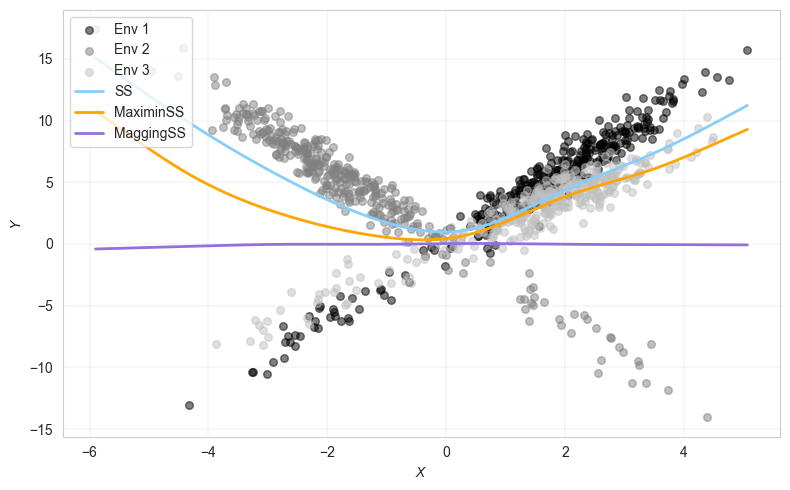

In [20]:
plot_dtr(dtr, x_grid, preds_erm, preds_maximin, preds_magging)

In [21]:
fitted_erm = N @ beta.value
max_mse(Ytr, fitted_erm, Etr, verbose=True)

Environment 0 MSE: 17.836853660669256
Environment 1 MSE: 21.6928059154672
Environment 2 MSE: 9.389590138809359


np.float64(21.6928059154672)

In [23]:
min_xplvar(Ytr, fitted_erm, Etr, verbose=True)

Environment 0 explained variance: 28.330149861458906
Environment 1 explained variance: 26.339246393146336
Environment 2 explained variance: 8.890155792128384


np.float64(8.890155792128384)

In [43]:
fitted_maximin = N @ beta_maximin.value
max_mse(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 MSE: 19.245922632735134
Environment 1 MSE: 19.2459201388871
Environment 2 MSE: 11.555686883058792


np.float64(19.245922632735134)

In [25]:
min_xplvar(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 explained variance: 30.558298853542333
Environment 1 explained variance: 12.7828173410659
Environment 2 explained variance: 12.780615770811863


np.float64(12.780615770811863)

In [26]:
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 46.41591576321005
Environment 1 MSE: 48.49238589236742
Environment 2 MSE: 18.41188524034525


np.float64(48.49238589236742)

In [27]:
min_xplvar(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 explained variance: -0.24891224108188936
Environment 1 explained variance: -0.46033358375388644
Environment 2 explained variance: -0.1321393094075063


np.float64(-0.46033358375388644)

## Smoothing Splines

In [11]:
def erm_ss(X, Y, lam):
    X = np.atleast_1d(X).flatten()

    idx = np.argsort(X)
    X = np.array(X)[idx]
    Y = np.array(Y)[idx]
    n = len(X)

    h = np.diff(X)

    Q = np.zeros((n-2, n))
    for i in range(n-2):
        hi, hip1 = h[i], h[i+1]
        Q[i, i]     =  1.0 / hi
        Q[i, i+1] = -1.0/hi - 1.0/hip1
        Q[i, i+2] =  1.0 / hip1

    R = np.zeros((n-2, n-2))
    for i in range(n-2):
        R[i, i] = (h[i] + h[i+1]) / 3.0
    for i in range(n-3):
        R[i, i+1] = h[i+1] / 6.0
        R[i+1, i] = h[i+1] / 6.0

    M = np.linalg.solve(R, Q)
    K = Q.T @ M  # = Q^T R^{-1} Q

    A = np.eye(n) + lam * K
    g_sorted = np.linalg.solve(A, Y)

    g_unsorted = np.empty_like(g_sorted)
    g_unsorted[idx] = g_sorted

    cs = CubicSpline(X, g_sorted, bc_type='natural')

    #g = cp.Variable(n)
    #rss = cp.sum_squares(Y - g)
    #penalty = lam * cp.sum_squares(K @ g)
    #objective = rss + penalty
    #prob = cp.Problem(cp.Minimize(objective))
    #prob.solve(solver=cp.SCS)

    #g_sorted = g.value
    #g_unsorted = np.empty_like(g_sorted)
    #g_unsorted[idx] = g_sorted

    #cs = CubicSpline(X, g.value, bc_type='natural')
    return g_unsorted, cs


def maximin_ss(X, Y, E, lam):
    X = np.atleast_1d(X).flatten()
    idx = np.argsort(X)
    X, Y, E = X[idx], Y[idx], E[idx]
    n = len(X)

    h = np.diff(X)

    Q = np.zeros((n-2, n))
    for i in range(n-2):
        hi, hip1 = h[i], h[i+1]
        Q[i, i]     =  1.0 / hi
        Q[i, i+1] = -1.0/hi - 1.0/hip1
        Q[i, i+2] =  1.0 / hip1

    R = np.zeros((n-2, n-2))
    for i in range(n-2):
        R[i, i] = (h[i] + h[i+1]) / 3.0
    for i in range(n-3):
        R[i, i+1] = h[i+1] / 6.0
        R[i+1, i] = h[i+1] / 6.0

    M = np.linalg.solve(R, Q)
    K = Q.T @ M

    g = cp.Variable(n)
    t = cp.Variable(nonneg=True)

    constraints = []
    for env in np.unique(E):
        mask = (E == env)
        constraints.append(
            cp.sum_squares(Y[mask] - g[mask]) / mask.sum() <= t
        )

    smooth_pen = lam * cp.sum_squares(K @ g)
    obj = cp.Minimize(t + smooth_pen)

    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS)

    g_sorted = g.value
    g_unsorted = np.empty_like(g_sorted)
    g_unsorted[idx] = g_sorted

    cs = CubicSpline(X, g.value, bc_type="natural")
    return g_unsorted, cs

In [12]:
g_erm, spline_func_erm = erm_ss(Xtr, Ytr, 0.1)
x_grid = np.linspace(min(Xtr), max(Xtr), 200)
preds_erm = spline_func_erm(x_grid)

In [13]:
idx = np.argsort(Xtr.flatten())
Xs = Xtr[idx].flatten()
Ys = Ytr[idx].flatten()

spline_func_erm_2 = make_smoothing_spline(Xs, Ys, w=None, lam=10)
preds_erm_2 = spline_func_erm_2(x_grid)

In [ ]:
g_maximin, spline_func_maximin = maximin_ss(Xtr, Ytr, Etr, 1, method='extragradient')
preds_maximin_2 = spline_func_maximin(x_grid)

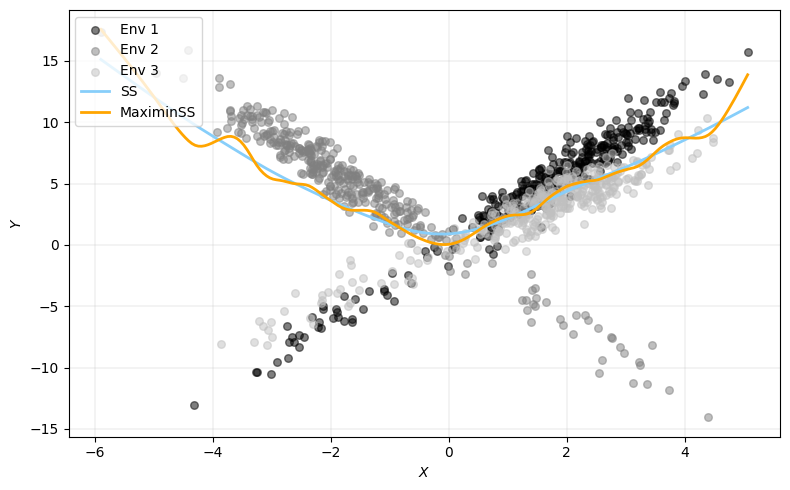

In [15]:
plot_dtr(dtr, x_grid, preds_erm_2, preds_maximin_2)

In [94]:
fitted_erm_2 = g_erm
max_mse(Ytr, fitted_erm_2, Etr, verbose=True)

Environment 0 MSE: 17.445688814673794
Environment 1 MSE: 21.359800032888256
Environment 2 MSE: 9.110184588408172


np.float64(21.359800032888256)

In [95]:
fitted_maximin_2 = g_maximin
max_mse(Ytr, fitted_maximin_2, Etr, verbose=True)

Environment 0 MSE: 19.47624335165984
Environment 1 MSE: 19.47624334297219
Environment 2 MSE: 11.463415118034586


np.float64(19.47624335165984)

In [59]:
from scipy.interpolate import make_smoothing_spline

def demonstrate_smoothing_splines():
    # Generate some noisy data
    np.random.seed(42)
    x = np.sort(np.random.uniform(0, 10, 20))
    y_true = np.sin(x)
    y_noisy = y_true + np.random.normal(0, 0.2, len(x))

    # Create evaluation points
    x_eval = np.linspace(min(x), max(x), 500)

    # Test different smoothing parameters
    smoothing_params = [0.1, 1.0, 10.0, 20.0]

    plt.figure(figsize=(15, 10))

    # Plot using SciPy's implementation
    plt.subplot(2, 1, 1)
    plt.scatter(x, y_noisy, color='red', label='Noisy data')
    plt.plot(x_eval, np.sin(x_eval), 'k--', lw=1, label='True function')

    for lam in smoothing_params:
        spline = make_smoothing_spline(x, y_noisy, lam=lam)
        plt.plot(x_eval, spline(x_eval), label=f'Smoothing: λ={lam}')

    plt.title("SciPy's UnivariateSpline with different smoothing factors")
    plt.legend()
    plt.grid(True)

    # Plot using custom implementation
    plt.subplot(2, 1, 2)
    plt.scatter(x, y_noisy, color='red', label='Noisy data')
    plt.plot(x_eval, np.sin(x_eval), 'k--', lw=1, label='True function')

    for lam in smoothing_params:
        g, spline_func = erm_ss(x, y_noisy, lam=lam)
        plt.scatter(x, g, color='blue', label='g')
        plt.plot(x_eval, spline_func(x_eval), label=f'Smoothing: λ={lam}')

    plt.title("Custom Smoothing Spline Implementation")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

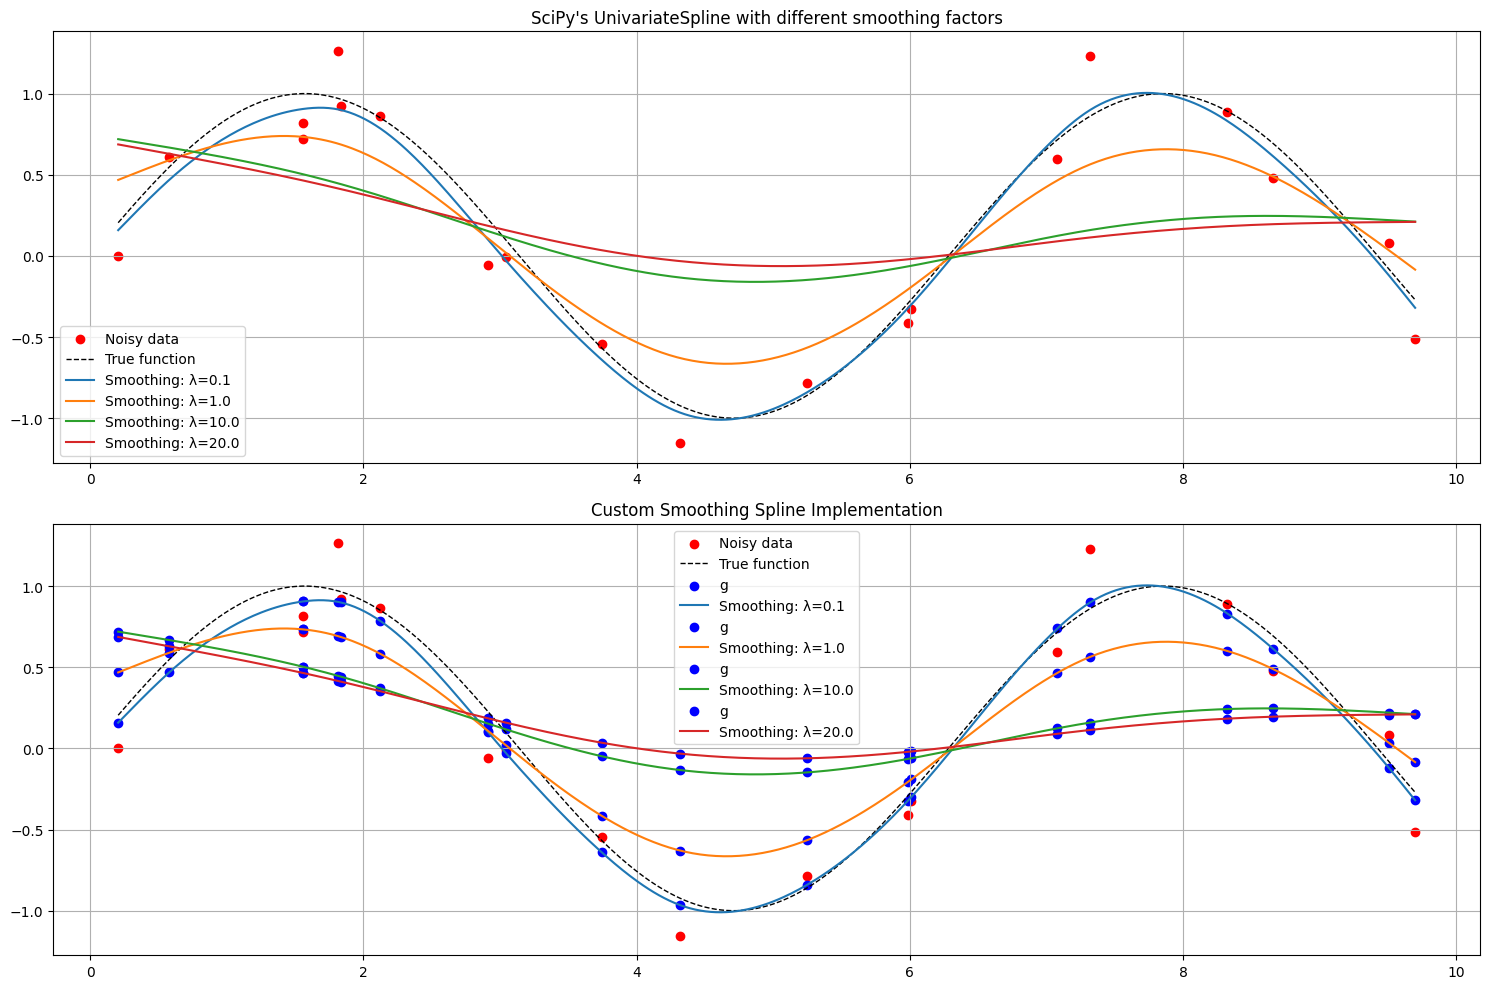

In [60]:
demonstrate_smoothing_splines()

In [61]:
def cross_validate_smoothing(x, y, k=5, lam_values=None, own=True):
    """
    Find optimal smoothing parameter using k-fold cross-validation

    Parameters:
    -----------
    x : array-like
        Independent variable values
    y : array-like
        Dependent variable values
    k : int
        Number of folds for cross-validation
    lam_values : array-like
        Lambda values to test

    Returns:
    --------
    optimal_lambda : float
        The lambda value with lowest cross-validation error
    cv_errors : array
        Mean squared errors for each lambda value
    """
    if lam_values is None:
        lam_values = np.logspace(-3, 3, 20)

    n = len(x)
    fold_size = n // k
    cv_errors = np.zeros(len(lam_values))

    # Sort data
    idx = np.argsort(x)
    x_sorted = x[idx]
    y_sorted = y[idx]

    # K-fold cross-validation
    for i, lam in enumerate(lam_values):
        fold_errors = np.zeros(k)

        for j in range(k):
            # Create validation mask
            val_mask = np.zeros(n, dtype=bool)
            val_mask[j*fold_size:(j+1)*fold_size] = True

            x_train = x_sorted[~val_mask]
            y_train = y_sorted[~val_mask]
            x_val = x_sorted[val_mask]
            y_val = y_sorted[val_mask]

            # Fit spline on training data
            if own:
                g, spline_func = erm_ss(x_train, y_train, lam=lam)
            else:
                spline_func = make_smoothing_spline(x_train, y_train, lam=lam)

            # Evaluate on validation data
            y_pred = spline_func(x_val)
            fold_errors[j] = np.mean((y_val - y_pred)**2)

        cv_errors[i] = np.mean(fold_errors)

    optimal_lambda = lam_values[np.argmin(cv_errors)]

    return optimal_lambda, cv_errors

Optimal lambda: 10.000000
Optimal lambda 2: 10.000000


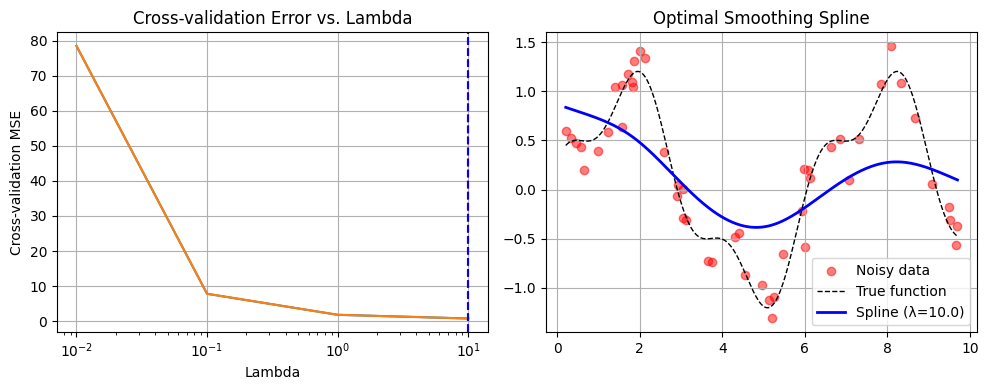

In [63]:
def main():
    # Generate some noisy data
    np.random.seed(42)
    x = np.sort(np.random.uniform(0, 10, 50))
    y_true = np.sin(x) + 0.3*np.cos(3*x)
    y_noisy = y_true + np.random.normal(0, 0.2, len(x))

    # Cross-validate to find optimal smoothing
    lam_values = [0.01, 0.1, 1, 10]
    optimal_lambda, cv_errors = cross_validate_smoothing(x, y_noisy, lam_values=lam_values)
    optimal_lambda_2, cv_errors_2 = cross_validate_smoothing(x, y_noisy, lam_values=lam_values, own=False)

    print(f"Optimal lambda: {optimal_lambda:.6f}")
    print(f"Optimal lambda 2: {optimal_lambda_2:.6f}")

    # Plot CV errors
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.semilogx(lam_values, cv_errors)
    plt.semilogx(lam_values, cv_errors_2)
    plt.axvline(optimal_lambda, color='r', linestyle='--')
    plt.axvline(optimal_lambda_2, color='blue', linestyle='--')
    plt.xlabel('Lambda')
    plt.ylabel('Cross-validation MSE')
    plt.title('Cross-validation Error vs. Lambda')
    plt.grid(True)

    # Fit with optimal parameter
    g, spline_func = erm_ss(x, y_noisy, lam=optimal_lambda)
    spline_func_2 = make_smoothing_spline(x, y_noisy, lam=optimal_lambda_2)

    # Evaluate on fine grid
    x_eval = np.linspace(min(x), max(x), 500)
    y_spline = spline_func(x_eval)
    y_spline_2 = spline_func_2(x_eval)

    # Plot results
    plt.subplot(1, 2, 2)
    plt.scatter(x, y_noisy, color='red', alpha=0.5, label='Noisy data')
    plt.plot(x_eval, np.sin(x_eval) + 0.3*np.cos(3*x_eval), 'k--', lw=1, label='True function')
    plt.plot(x_eval, y_spline, 'b-', lw=2, label=f'Spline (λ={optimal_lambda:.1f})')
    #plt.plot(x_eval, y_spline_2, 'r-', lw=2, label=f'Spline Scipy (λ={optimal_lambda_2:.1f})')
    plt.legend()
    plt.title('Optimal Smoothing Spline')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()